# Preparing NEI-SMOKE format emissions using eGRID-based output

This is the emission processing for the second "prong" of LOCAETA's three decarbonization strategies, electrification. The goal of the study is assessing the impact of changes of energy demands given a grid scenario (e.g., current and 2050 grid). For example, what will be the emissions increases at power plants in the region of the facility(ies)? We explored the hypothetical scenario which essentially assumes that each power plant in the region (region defined by NREL’s Cambium model) marginally increases its output to collectively meet an additional 300MW load that would be incurred if the data center were connected to the grid.

About the emissions generated from eGRID, it is computed for each powerplant facility (EIS ID is a unique identifier). To include these emissions into NEI-SMOKE formated emissions, I need to split the emisisons using 2020 NEI emissions (per EIS ID and per SCC). 

Here is the emissions scenarios considered and the stretegy I use to prepare NEI-SMOKE style emissions for each scenario: 

* current_2020  - emissions can be prepared by splitting into each SCC by the NEI 2020 emissions weight
* decarb95_2050 - can be prepared by splitting into each SCC by the NEI 2020 emissions weight
* highREcost_2050 -  can be prepared by splitting into each SCC by the NEI 2020 emissions weight


## Step 1: Read eGRID emissions and NEI-SMOKE all point source shapefile

In [250]:
import pandas as pd
import geopandas as gpd
import os

def reformat_egrid(egrid):
    # columns I need
    pollutant_cols = [col for col in egrid.columns if '_tons_final' in col]
    base_cols = [col for col in egrid.columns if '_tons_base' in col]
    egrid_col_names = pollutant_cols + base_cols + ['ghgrp_facility_id', 'oris', 'eis']

    # subset the dataframe 
    egrid = egrid[egrid_col_names] 

    # remove rows if ghgrp_facility_id is NaN, which is the case for renewable energy rows
    egrid = egrid.dropna(subset=['ghgrp_facility_id'])

    # Define columns as integers
    egrid = egrid.astype({'ghgrp_facility_id': 'int64', 'oris': 'int64', 'eis': 'int64'})

    # rename "eis" to "eis_id"
    egrid.rename(columns={'eis': 'EIS_ID', 'oris':'oris_id'}, inplace=True)

    print(egrid.head())

    return egrid

from itertools import combinations

def find_minimal_unique_identifier_columns(df, max_combination_size=30):
    """
    Finds the minimal set of columns that uniquely identify rows in a DataFrame.

    Args:
        df: pandas.DataFrame
        max_combination_size: int, maximum number of columns to consider in combinations (avoid long runtime)

    Returns:
        List of column names or None
    """
    cols = df.columns.tolist()
    for r in range(1, min(len(cols), max_combination_size) + 1):
        for combo in combinations(cols, r):
            if not df.duplicated(subset=combo).any():
                return list(combo)
    return None

def mapping_egrid_to_nei(nei_with_egrid, nei_all_pt, unique_identifier_columns):

    # Column mapping between NEI and eGRID
    pollutant_map = {
        'NOx': 'NOx_tons_final',
        'PM2_5': 'PM2.5_tons_final',
        'VOC': 'VOC_tons_final',
        'NH3': 'NH3_tons_final',
        'SOx': 'SO2_tons_final'

    }

    #print("before", nei_with_egrid.head())
    # Compute and apply split factors per pollutant
    for nei_col, egrid_col in pollutant_map.items():

        print (nei_col, egrid_col)
        # Group sum for each pollutant by EIS_ID
        total_by_eis = nei_with_egrid.groupby('EIS_ID')[f'{nei_col}_nei'].transform('sum')
        nei_with_egrid[f'{nei_col}_total_by_eis'] = total_by_eis

        # Default: compute split factor using NEI emissions
        split_col = f'{nei_col}_split'
        nei_with_egrid[split_col] = nei_with_egrid[f'{nei_col}_nei'] / total_by_eis.replace(0, pd.NA)

        # Find EIS_IDs where total_by_eis is zero but eGRID_col is non-zero
        mask_zero_total = (total_by_eis == 0) & nei_with_egrid[egrid_col].notna() & (nei_with_egrid[egrid_col] != 0)

        # For these EIS_IDs, assign equal split factor across matching rows
        for eid in nei_with_egrid.loc[mask_zero_total, 'EIS_ID'].unique():
            match_rows = nei_with_egrid['EIS_ID'] == eid
            n_rows = match_rows.sum()
            nei_with_egrid.loc[match_rows, split_col] = 1.0 / n_rows

        # Now compute eGRID-scaled emissions and save as nei original name
        nei_with_egrid[f'{nei_col}'] = nei_with_egrid[split_col] * nei_with_egrid[egrid_col]

    # OPTIONAL: Drop intermediate split columns
    #nei_with_egrid.drop(columns=[f'{k}_split' for k in pollutant_map], inplace=True)
    # Merge results back into the full NEI dataset

    # Merge results back into the full NEI dataset
    nei_all_pt_final = nei_all_pt.merge(
        nei_with_egrid[
            unique_identifier_columns + [f'{k}' for k in pollutant_map]
        ],
        on=unique_identifier_columns,
        how='left'
    )

    for k in pollutant_map:
        nei_all_pt_final[f'{k}'] = nei_all_pt_final[f'{k}'].fillna(nei_all_pt_final[f'{k}_nei'])


    return nei_all_pt_final

In [247]:
import geopandas as gpd
import os

egrid_dir_path = '/Users/yunhalee/Documents/LOCAETA/eGRID_emissions/'
nei_pt_emis_file_path = '/Users/yunhalee/Documents/LOCAETA/RCM/INMAP/evaldata_v1.6.1/2020_nei_emissions/combined_NEI2020_pt_oilgas_ptegu_ptnonipm.shp'

# read base and sens emission scenarios
nei_all_pt = gpd.read_file(nei_pt_emis_file_path) 

# Reset index to ensure proper comparison
nei_all_pt.reset_index(drop=True, inplace=True)

print(nei_all_pt.head())

# rename the nei emissions
pollutant_cols = ['NOx','PM2_5', 'VOC','NH3', 'SOx']

col_dict = {}
for poll in pollutant_cols:
    col_dict[poll] = f'{poll}_nei'

nei_all_pt.rename(columns = col_dict, inplace=True)

# remove duplicates
print(nei_all_pt[nei_all_pt.duplicated()])
nei_all_pt = nei_all_pt[~nei_all_pt.duplicated()]

    FIPS       SCC     VOC         NOx       NH3       SOx     PM2_5  height  \
0  06031  20200201  0.0433    2.549257  1.126784  0.053919  0.291721  12.192   
1  06031  20100201  0.0612    1.286907  0.476615  0.034398  0.219812  12.192   
2  06013  20100201  0.0000   85.243000  0.000000  6.901000  0.000000  12.192   
3  06013  20300203  0.0000  121.232000  0.000000  8.240000  0.000000  12.192   
4  05119  20100201  2.2338  203.600000  0.000000  6.014635  8.208184   0.000   

     diam        temp  velocity  EIS_ID                          geometry  
0  0.6096  138.888890     15.24   16711  POINT (-2023790.714 -159536.923)  
1  0.6096  138.888890     15.24   17611  POINT (-2000782.581 -162054.741)  
2  0.6096  138.888890     15.24  148911    POINT (-2139997.488 76811.449)  
3  0.6096  138.888890     15.24  150711    POINT (-2138008.892 74564.843)  
4  0.0000  255.372222      0.00  210811    POINT (436639.837 -587000.143)  
         FIPS       SCC   VOC_nei  NOx_nei  NH3_nei   SOx_nei  

In [251]:


egrids_list = ["highREcost_2050", "decarb95_2050", "current_2020"] 

for egrid_name in egrids_list:

    print ("processing ", egrid_name)
    egrid_file = os.path.join(egrid_dir_path, f'ProjectX_{egrid_name}.csv')
    egrid = pd.read_csv(egrid_file) 

    egrid = reformat_egrid(egrid)

    # Filter NEI rows to only those that exist in eGRID
    nei_with_egrid = nei_all_pt[nei_all_pt['EIS_ID'].isin(egrid['EIS_ID'])].copy()

    # Subset only for necessary columns
    nei_with_egrid.drop(columns=['height', 'diam',
        'temp', 'velocity'], inplace=True)

    unique_identifier_columns = find_minimal_unique_identifier_columns(nei_with_egrid)

    if unique_identifier_columns:
        print("Columns that uniquely identify rows:", unique_identifier_columns)
    else:
        print("No combination of columns uniquely identifies rows.")

    print("filtering", nei_with_egrid.shape)

    # Merge eGRID emissions
    nei_with_egrid = nei_with_egrid.merge(egrid, on='EIS_ID', how='left')

    print("Merging egrid", nei_with_egrid.shape)

    nei_all_pt_final = mapping_egrid_to_nei(nei_with_egrid, nei_all_pt, unique_identifier_columns)
    
    # save output files
    filepath = egrid_dir_path  + egrid_name +"_debugging.csv"
    nei_with_egrid.to_csv(filepath)

    filepath = egrid_dir_path  + egrid_name +".shp"
    nei_all_pt_final.to_file(filepath, driver='ESRI Shapefile')

    print(nei_all_pt_final.shape, nei_all_pt.shape)
    print(nei_all_pt_final['PM2_5'].notna().sum())
    print(nei_with_egrid['PM2_5'].notna().sum())
    print(nei_with_egrid['PM2.5_tons_final'].notna().sum())

processing  highREcost_2050
    NOx_tons_final  SO2_tons_final  PM2.5_tons_final  NH3_tons_final  \
1      1101.837906      646.152639        162.323245       81.786471   
3        30.307911        0.000000          2.340053        0.997759   
4       759.123408        3.649632         37.910550       17.331467   
16     1142.030920      366.416720         48.167712       16.413115   
19       10.036487        1.824816          0.374087        0.172549   

    VOC_tons_final  NOx_tons_base  SO2_tons_base  PM2.5_tons_base  \
1       147.670073    1099.094681     644.543925       161.919112   
3         1.564734      30.232454       0.000000         2.334227   
4        20.656916     757.233433       3.640545        37.816165   
16       62.552995    1139.187626     365.504459        48.047789   
19        0.054744      10.011500       1.820273         0.373156   

    NH3_tons_base  VOC_tons_base  ghgrp_facility_id  oris_id   EIS_ID  
1       81.582849     147.302422            1001412 

/var/folders/c8/7t_s93rd22l4mk18hd7pj0d80000gn/T/ipykernel_91339/2449707954.py:98: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  nei_all_pt_final[f'{k}'] = nei_all_pt_final[f'{k}'].fillna(nei_all_pt_final[f'{k}_nei'])


(300004, 18) (300004, 13)
300004
641
641
processing  decarb95_2050
    NOx_tons_final  SO2_tons_final  PM2.5_tons_final  NH3_tons_final  \
1       362.745768       73.152647         20.629917       16.952709   
3         3.680150        0.000000          0.284142        0.121153   
4        92.176850        0.443158          4.603303        2.104480   
16      135.708608       27.262793          7.396569        6.050736   
19        1.218684        0.221579          0.045424        0.020952   

    VOC_tons_final  NOx_tons_base  SO2_tons_base  PM2.5_tons_base  \
1        82.823104     361.954277      72.993032        20.584903   
3         0.189998       3.672120       0.000000         0.283522   
4         2.508274      91.975725       0.442191         4.593259   
16       30.008080     135.412499      27.203307         7.380430   
19        0.006647       1.216025       0.221095         0.045325   

    NH3_tons_base  VOC_tons_base  ghgrp_facility_id  oris_id   EIS_ID  
1       16.91

/var/folders/c8/7t_s93rd22l4mk18hd7pj0d80000gn/T/ipykernel_91339/2449707954.py:98: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  nei_all_pt_final[f'{k}'] = nei_all_pt_final[f'{k}'].fillna(nei_all_pt_final[f'{k}_nei'])


(300004, 18) (300004, 13)
300004
641
641
processing  current_2020
    NOx_tons_final  SO2_tons_final  PM2.5_tons_final  NH3_tons_final  \
1      1664.501119     1290.591448        319.139946      146.021721   
3        33.388023        0.000000          2.577866        1.099159   
4       836.271094        4.020534         41.763298       19.092818   
16     2266.576102      763.901480         91.828999       23.336328   
19       11.056469        2.010267          0.412105        0.190084   

    VOC_tons_final  NOx_tons_base  SO2_tons_base  PM2.5_tons_base  \
1       146.005696      1656.0000         1284.0         317.5100   
3         1.723754        33.2175            0.0           2.5647   
4        22.756223       832.0000            4.0          41.5500   
16       73.284285      2255.0000          760.0          91.3600   
19        0.060308        11.0000            2.0           0.4100   

    NH3_tons_base  VOC_tons_base  ghgrp_facility_id  oris_id   EIS_ID  
1      145.275

/var/folders/c8/7t_s93rd22l4mk18hd7pj0d80000gn/T/ipykernel_91339/2449707954.py:98: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  nei_all_pt_final[f'{k}'] = nei_all_pt_final[f'{k}'].fillna(nei_all_pt_final[f'{k}_nei'])


(300004, 18) (300004, 13)
300004
641
641


### Useful debugging script

In [236]:
# check the number of unique IDs
ID_name = 'EIS_ID'
org_egrid_list = egrid[ID_name].unique()
egrid_list = nei_with_egrid[ID_name].unique()
org_nei_list = nei_all_pt[ID_name].unique()
nei_list = nei_all_pt_final[ID_name].unique()

print(len(org_egrid_list), len(egrid_list), len(nei_list),len(org_nei_list))


# find the rows where two columns are different
missing_pm25_egrid = nei_with_egrid[
    nei_with_egrid['PM2_5_egrid'].isna() & 
    nei_with_egrid['PM2.5_tons_final'].notna()
]

# filtering column based on string
missing_pm25_egrid.filter(regex ='tons_final|total_by_eis')


# get a certain ID facility
print(nei_all_pt[(nei_all_pt['EIS_ID'] == 1028611)])

87 87 76792 76792
         FIPS       SCC  VOC  NOx    NH3  SOx  PM2_5   height     diam  \
118863  01129  10100202  0.0  0.0  0.000  0.0    0.0  126.492  5.54736   
118864  01129  30510103  0.0  0.0  0.000  0.0    0.0    0.000  0.00000   
118865  01129  39999999  0.0  0.0  0.017  0.0    0.0    0.000  0.00000   

              temp  velocity   EIS_ID                        geometry  
118863   72.222220  14.35303  1028611  POINT (863142.428 -900553.000)  
118864  255.372222   0.00000  1028611  POINT (863060.260 -900439.066)  
118865  255.372222   0.00000  1028611  POINT (863142.428 -900553.000)  


# Compare NEI2020 against Current grid base emissions

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


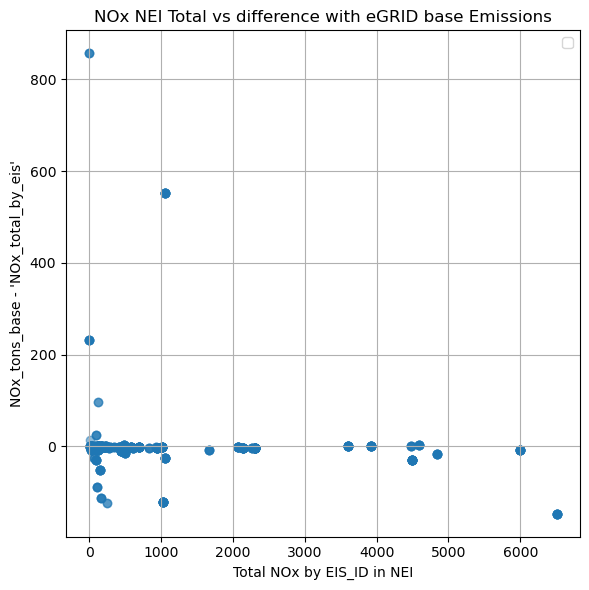

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


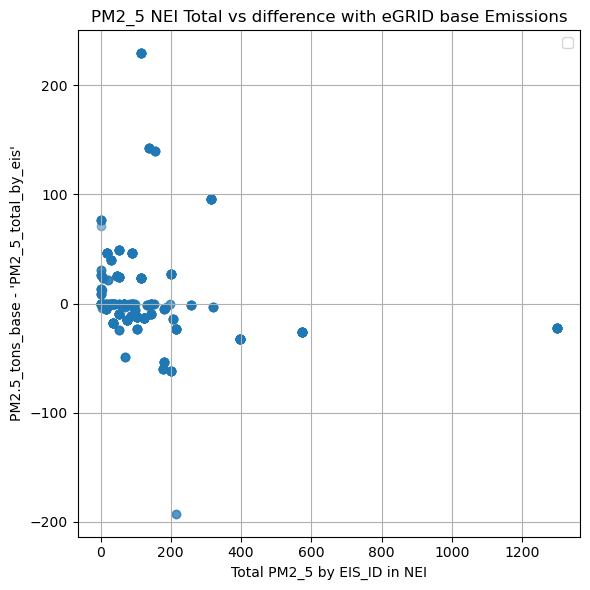

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


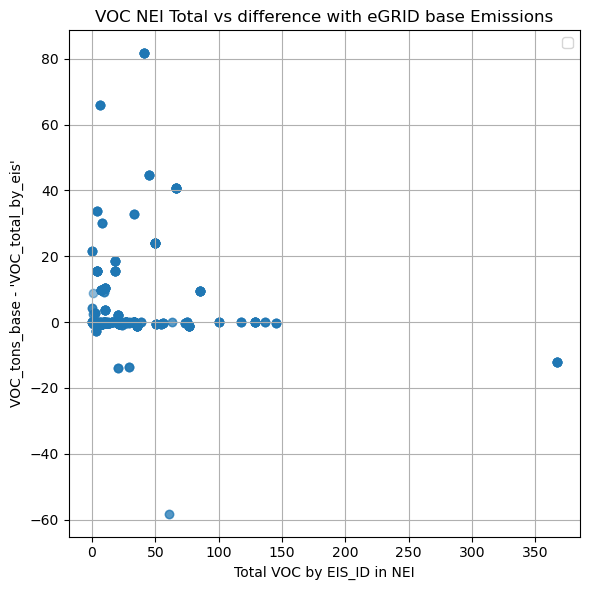

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


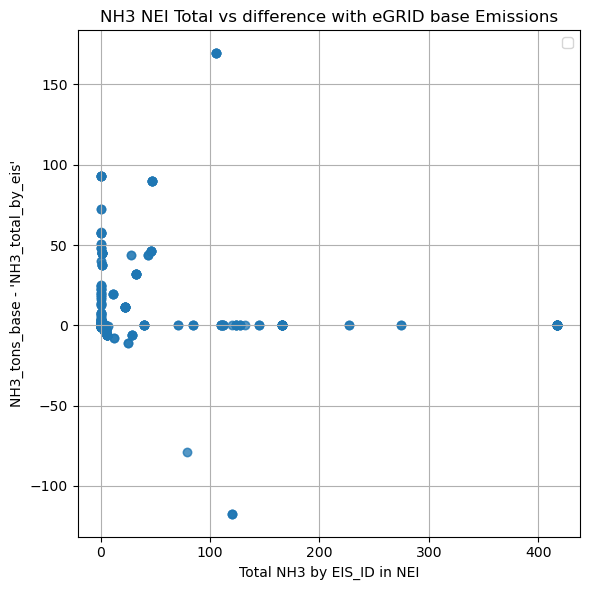

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


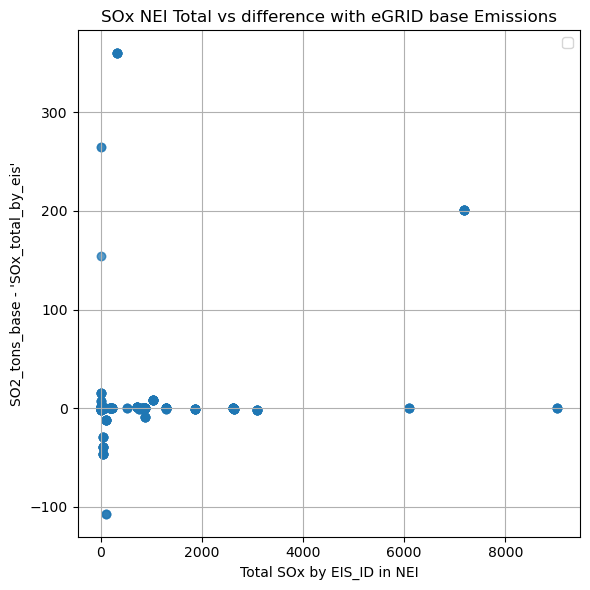

In [202]:
import matplotlib.pyplot as plt

# Column mapping between NEI and eGRID
pollutant_map = {
    'NOx': 'NOx_tons_base',
    'PM2_5': 'PM2.5_tons_base',
    'VOC': 'VOC_tons_base',
    'NH3': 'NH3_tons_base',
    'SOx': 'SO2_tons_base'

}

# Compute and apply split factors per pollutant
for nei_col, egrid_col in pollutant_map.items():
    # Scatter plot of total_by_eis vs. eGRID
    plt.figure(figsize=(6, 6))
    plt.scatter(
        nei_with_egrid[f'{nei_col}_total_by_eis'],
        nei_with_egrid[egrid_col] - nei_with_egrid[f'{nei_col}_total_by_eis'],
        alpha=0.5
    )
    plt.xlabel(f"Total {nei_col} by EIS_ID in NEI")
    plt.ylabel(f"{egrid_col} - '{nei_col}_total_by_eis'")
    plt.title(f"{nei_col} NEI Total vs difference with eGRID base Emissions")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



## Evaluate new egrid emissions formatted for NEI-SMOKE style

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


processing  current_2020
    NOx_tons_final  SO2_tons_final  PM2.5_tons_final  NH3_tons_final  \
1      1664.501119     1290.591448        319.139946      146.021721   
3        33.388023        0.000000          2.577866        1.099159   
4       836.271094        4.020534         41.763298       19.092818   
16     2266.576102      763.901480         91.828999       23.336328   
19       11.056469        2.010267          0.412105        0.190084   

    VOC_tons_final  NOx_tons_base  SO2_tons_base  PM2.5_tons_base  \
1       146.005696      1656.0000         1284.0         317.5100   
3         1.723754        33.2175            0.0           2.5647   
4        22.756223       832.0000            4.0          41.5500   
16       73.284285      2255.0000          760.0          91.3600   
19        0.060308        11.0000            2.0           0.4100   

    NH3_tons_base  VOC_tons_base  ghgrp_facility_id  oris_id   EIS_ID  
1      145.275943      145.26000            1001412    

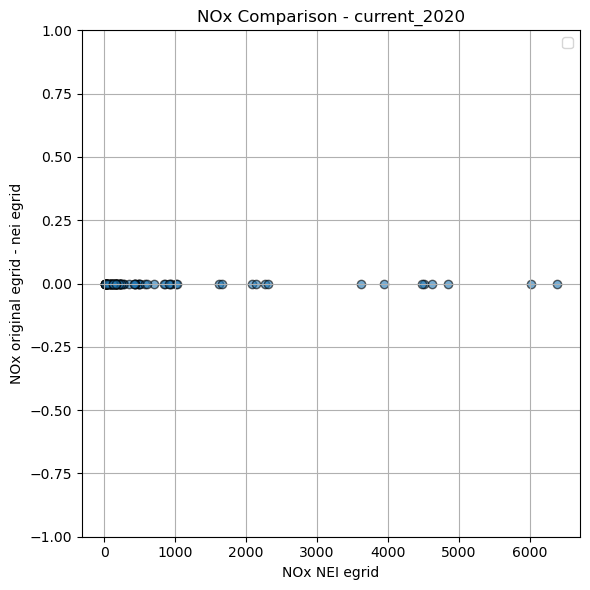

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


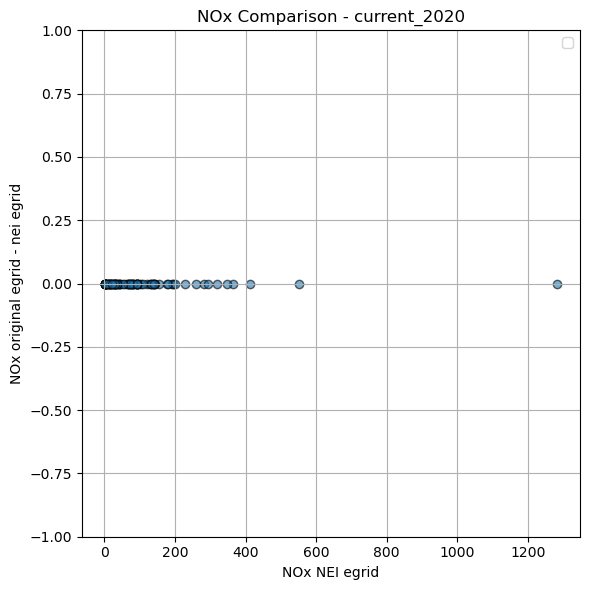

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


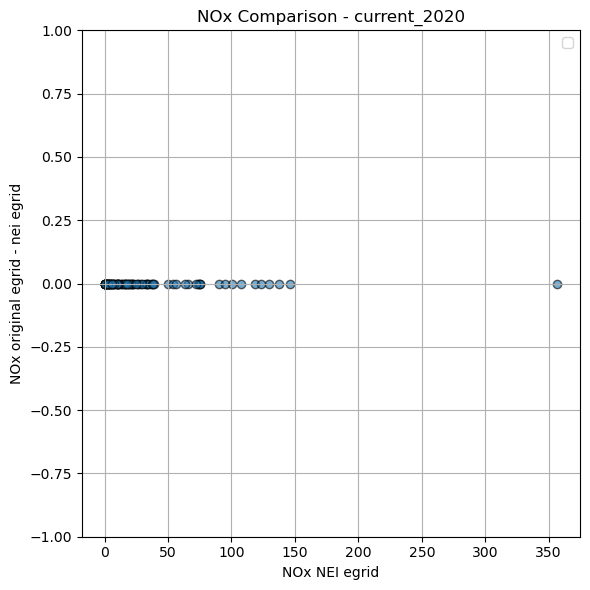

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


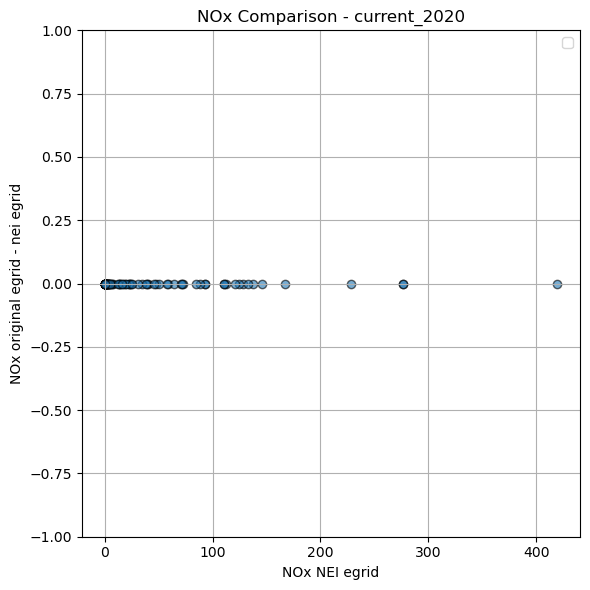

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


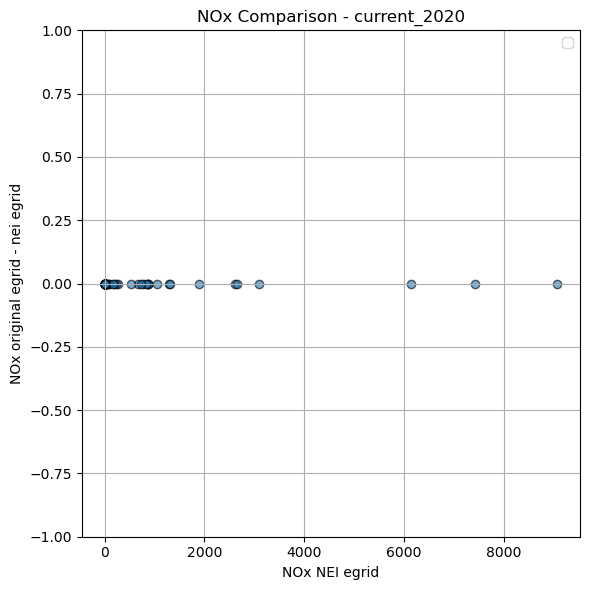

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


processing  decarb95_2050
    NOx_tons_final  SO2_tons_final  PM2.5_tons_final  NH3_tons_final  \
1       362.745768       73.152647         20.629917       16.952709   
3         3.680150        0.000000          0.284142        0.121153   
4        92.176850        0.443158          4.603303        2.104480   
16      135.708608       27.262793          7.396569        6.050736   
19        1.218684        0.221579          0.045424        0.020952   

    VOC_tons_final  NOx_tons_base  SO2_tons_base  PM2.5_tons_base  \
1        82.823104     361.954277      72.993032        20.584903   
3         0.189998       3.672120       0.000000         0.283522   
4         2.508274      91.975725       0.442191         4.593259   
16       30.008080     135.412499      27.203307         7.380430   
19        0.006647       1.216025       0.221095         0.045325   

    NH3_tons_base  VOC_tons_base  ghgrp_facility_id  oris_id   EIS_ID  
1       16.915719      82.642388            1001412   

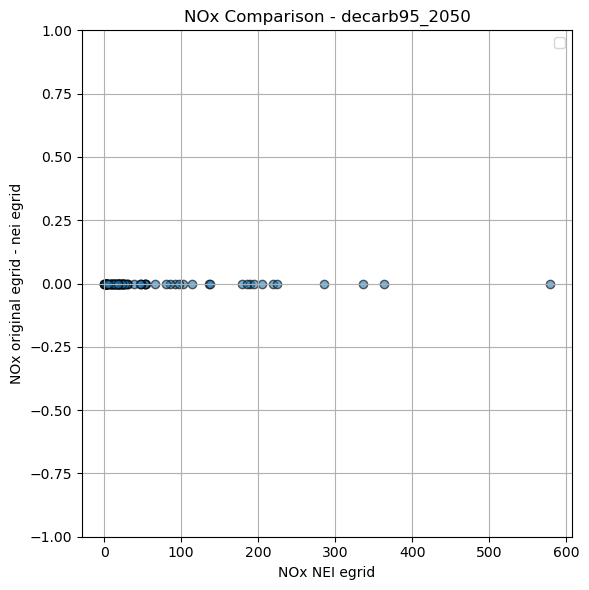

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


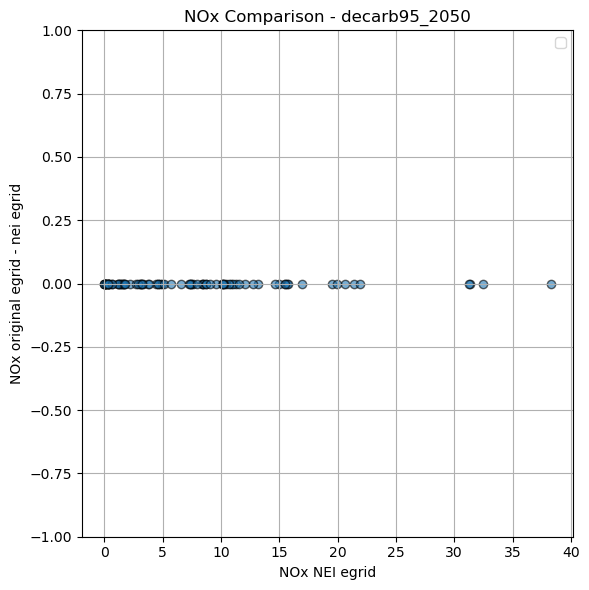

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


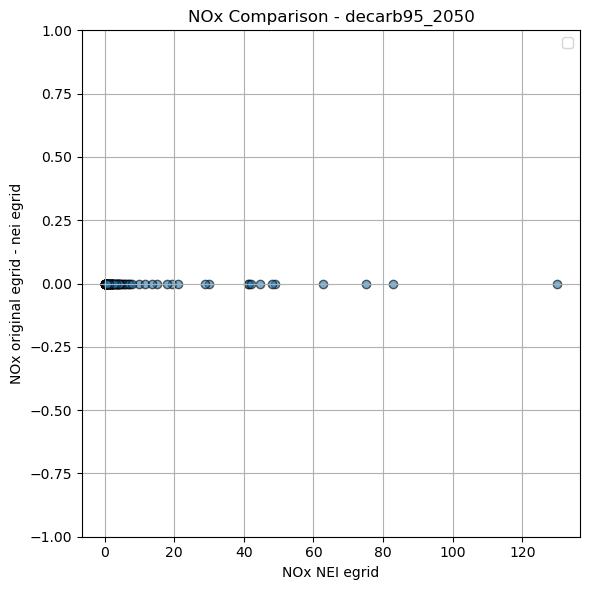

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


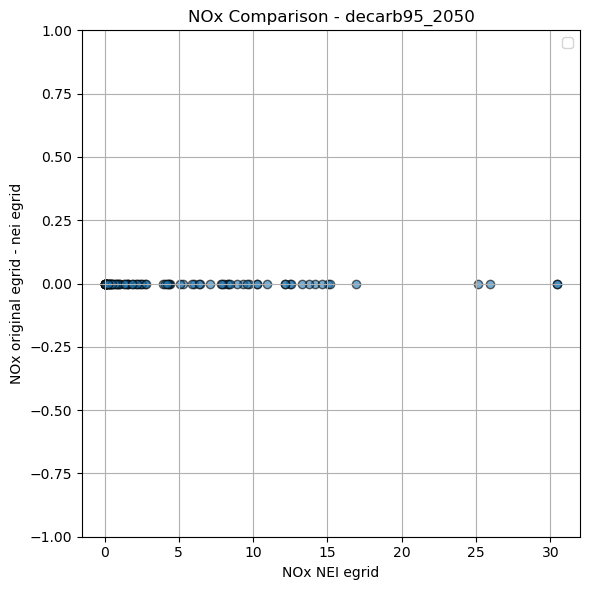

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


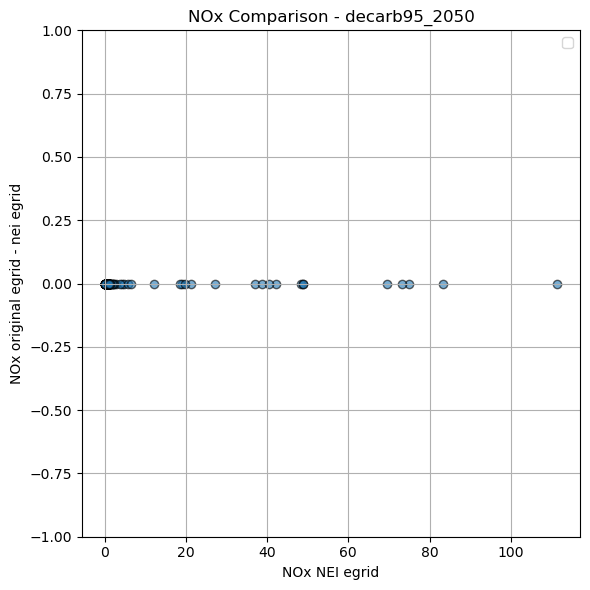

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


processing  highREcost_2050
    NOx_tons_final  SO2_tons_final  PM2.5_tons_final  NH3_tons_final  \
1      1101.837906      646.152639        162.323245       81.786471   
3        30.307911        0.000000          2.340053        0.997759   
4       759.123408        3.649632         37.910550       17.331467   
16     1142.030920      366.416720         48.167712       16.413115   
19       10.036487        1.824816          0.374087        0.172549   

    VOC_tons_final  NOx_tons_base  SO2_tons_base  PM2.5_tons_base  \
1       147.670073    1099.094681     644.543925       161.919112   
3         1.564734      30.232454       0.000000         2.334227   
4        20.656916     757.233433       3.640545        37.816165   
16       62.552995    1139.187626     365.504459        48.047789   
19        0.054744      10.011500       1.820273         0.373156   

    NH3_tons_base  VOC_tons_base  ghgrp_facility_id  oris_id   EIS_ID  
1       81.582849     147.302422            1001412 

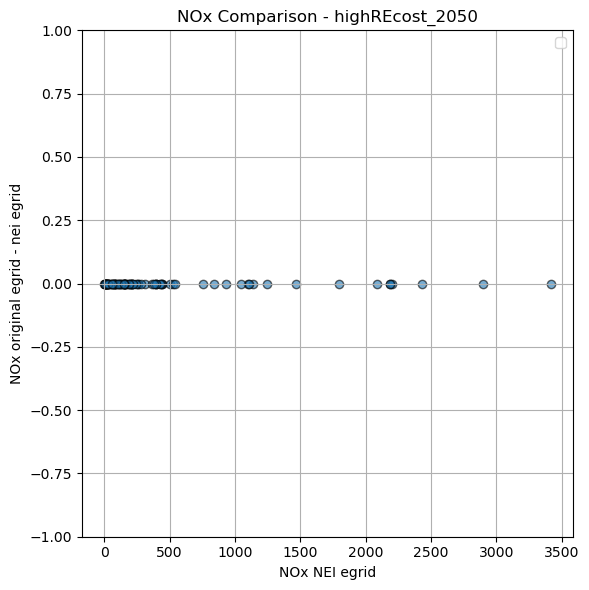

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


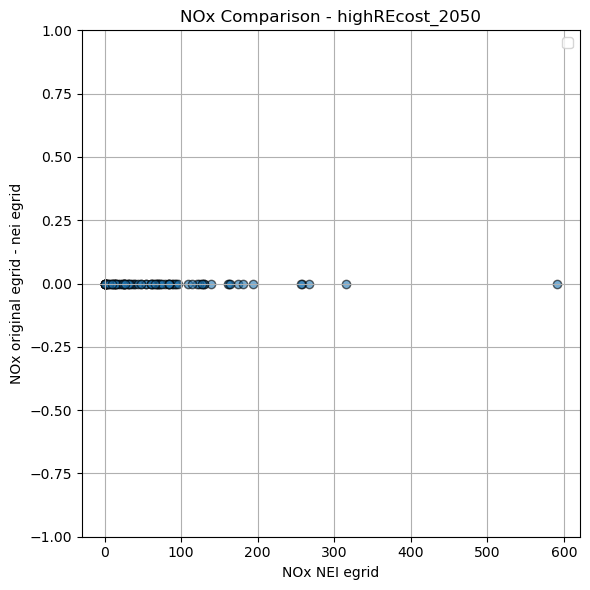

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


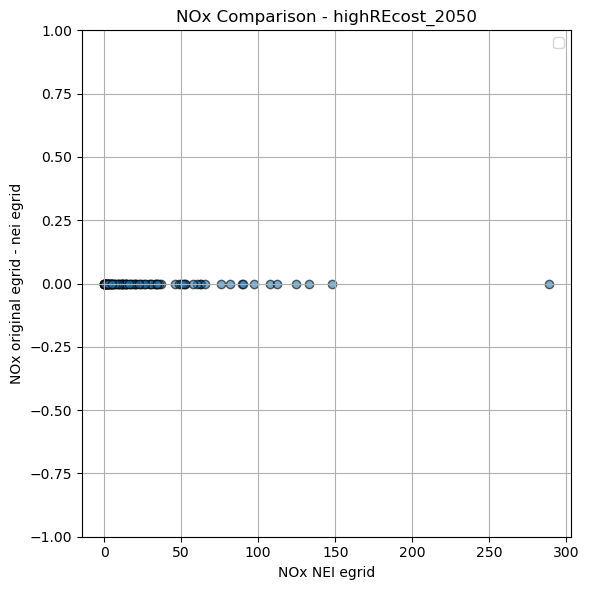

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


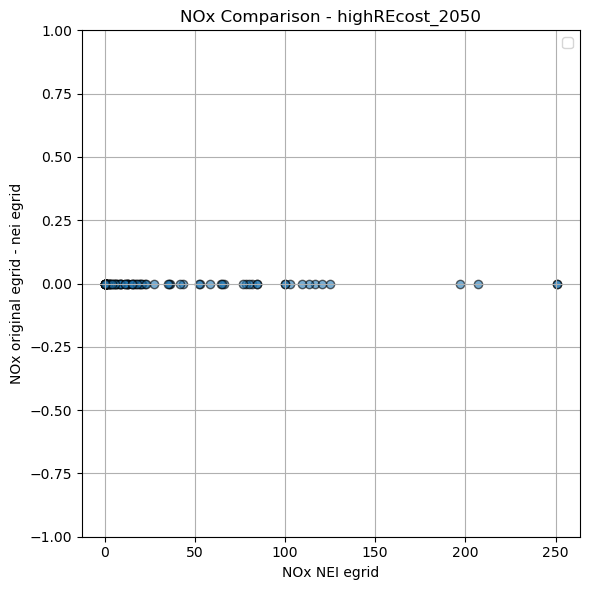

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


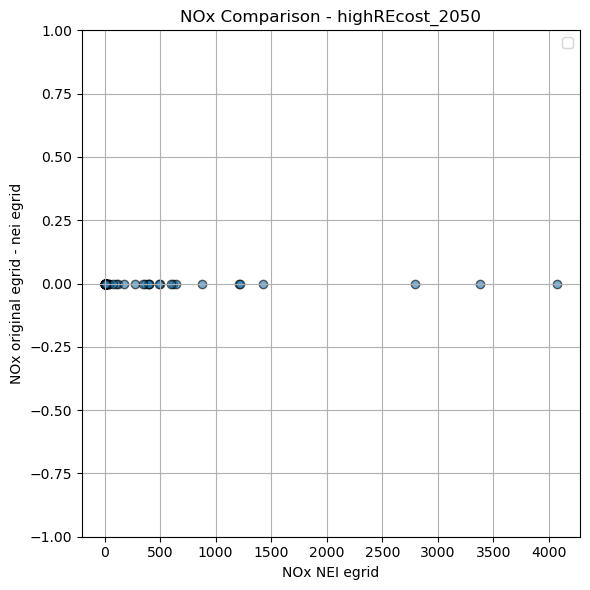

In [271]:
import geopandas as gpd
import os


egrid_dir_path = '/Users/yunhalee/Documents/LOCAETA/eGRID_emissions/'
egrids_list = ["current_2020","decarb95_2050","highREcost_2050"]


# Column mapping between NEI and eGRID
pollutant_map = {
    'NOx': 'NOx_tons_final',
    'PM2_5': 'PM2.5_tons_final',
    'VOC': 'VOC_tons_final',
    'NH3': 'NH3_tons_final',
    'SOx': 'SO2_tons_final'

}

# nei emissions column names
pollutant_cols = ['NOx','PM2_5', 'VOC','NH3', 'SOx']

for egrid_name in egrids_list:

    file_path = os.path.join(egrid_dir_path, f'{egrid_name}.shp')  
    # read emission scenario
    final_egrid_emis = gpd.read_file(file_path) 

    # Reset index to ensure proper comparison
    final_egrid_emis.reset_index(drop=True, inplace=True)

    # Subset rows where actual egrid emissions are available (egrid ≠ nei for any pollutant)
    mask = pd.concat([
        final_egrid_emis[k] != final_egrid_emis[f'{k}_nei']
        for k in pollutant_cols
    ], axis=1).any(axis=1)

    final_egrid_emis = final_egrid_emis[mask]

    # Compute group sums for each pollutant by EIS_ID
    group_sums = final_egrid_emis.groupby('EIS_ID')[[k for k in pollutant_cols]].sum().reset_index()

    group_sums.head()

    print ("processing ", egrid_name)
    original_egrid_file = os.path.join(egrid_dir_path, f'ProjectX_{egrid_name}.csv')
    original_egrid = pd.read_csv(original_egrid_file) 
    original_egrid = reformat_egrid(original_egrid)


    # Merge for comparison
    comparison_df = group_sums.merge(original_egrid, on='EIS_ID')
    comparison_df.head()

    # Scatter plots
    for nei, egrid in pollutant_map.items():
        x = comparison_df[nei]
        y = comparison_df[egrid] - comparison_df[nei]

        plt.figure(figsize=(6, 6))
        plt.scatter(x, y, alpha=0.6, edgecolors='k')
        plt.xlabel(f'{pol} NEI egrid')
        plt.ylabel(f'{pol} original egrid - nei egrid')
        plt.ylim(-1, 1)
        plt.title(f'{pol} Comparison - {egrid_name}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
